In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
import torch.utils.data as Data
%matplotlib inline

# Structure of ResNet18

In [3]:
class ResidualBlock(nn.Module):
    def __init__(self, c_in, c_out, conv1x1, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(c_in, c_out, kernel_size=3, padding=1, stride=stride)
        self.conv2 = nn.Conv2d(c_out, c_out, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()   
        self.bn1 = nn.BatchNorm2d(c_out)    # must use 2 bn layers
        self.bn2 = nn.BatchNorm2d(c_out)

        if conv1x1:
            self.conv3 = nn.Conv2d(c_in, c_out, kernel_size=1, stride=stride)
        else:
            self.conv3 = None
        
    def forward(self, imgs): # (batch_size, channels, height, weight)
        x = self.conv1(imgs) # batch_size, c_out, h, w
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        if self.conv3 is not None:
            imgs = self.conv3(imgs)
        
        return self.relu(x + imgs)

In [10]:
img1 = torch.randn([3, 1, 28, 28])
net = ResidualBlock(1, 3, True, 2)
y = net(img1)
y.shape

torch.Size([3, 3, 14, 14])

In [19]:
class ResNet18(nn.Module):
    def __init__(self, c_in, img_size):   # 1 or 3
        super().__init__()
        self.conv1 = nn.Conv2d(c_in, 64, kernel_size=7, stride=2, padding=3)  
        self.bn1 = nn.BatchNorm2d(64)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = nn.Sequential(
            ResidualBlock(64, 64, False, 1),
            ResidualBlock(64, 64, False, 1),            
        )
        self.layer2 = nn.Sequential(
            ResidualBlock(64, 128, True, 2),
            ResidualBlock(128, 128, False, 1),
        )
        self.layer3 = nn.Sequential(
            ResidualBlock(128, 256, True, 2),
            ResidualBlock(256, 256, False, 1),
        )
        self.layer4 = nn.Sequential(
            ResidualBlock(256, 512, True, 2),
            ResidualBlock(512, 512, False, 1),
        )
        self.avgpool = nn.AvgPool2d(kernel_size=int(img_size/32), stride=1)   # batch_size, 512, 1, 1
        self.fc = nn.Linear(512, 10)

    def forward(self, imgs): # (batch_size, channels, height, weight)
        x = self.conv1(imgs)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x).view(x.shape[0], -1)
        x = self.fc(x)
        return x        

In [63]:
net = ResNet18(1, 64)
imgs = torch.randn([3, 1, 64, 64])
y = net(imgs)
y.shape 

torch.Size([3, 64, 32, 32])
torch.Size([3, 64, 32, 32])
torch.Size([3, 64, 32, 32])
torch.Size([3, 64, 16, 16])
torch.Size([3, 64, 16, 16])
torch.Size([3, 128, 8, 8])
torch.Size([3, 256, 4, 4])
torch.Size([3, 512, 2, 2])
torch.Size([3, 512])


torch.Size([3, 10])

# Get data and train resnet18

In [5]:
root = 'Datasets/FashionMNIST'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomResizedCrop(size=(128, 128), antialias=True)
])

train_data = torchvision.datasets.FashionMNIST(root, train=True, download=False, transform=transform)
test_data = torchvision.datasets.FashionMNIST(root, train=False, download=False, transform=transform)

train_iter = Data.DataLoader(train_data, batch_size=512, shuffle=True)
test_iter = Data.DataLoader(test_data, batch_size=512, shuffle=False)

In [50]:
X, y = iter(train_iter).__next__()
X.shape, y.shape

(torch.Size([512, 1, 224, 224]), torch.Size([512]))

In [53]:
train_data.data.shape

torch.Size([60000, 28, 28])

In [21]:
torch.manual_seed(42)
torch.cuda.empty_cache()

net = nn.Sequential(
    ResNet18(1, 128)
)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0.1)
device = "cuda" if torch.cuda.is_available() else "cpu"
idx = 0
t_loss = []
e_loss = []

loss.to(device)
loss.to(device)

for i in range(1):
    for X, y in train_iter:
        net.train()
        
        # forward pass
        X.to(device), y.to(device)     
        logits = net(X)
        l = loss(logits, y)
        
        # backward pass
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        # track stats
        t_loss.append(l.item())
        idx += 1
        print(f'epoch {idx : 7d} , train loss {l.item() : 10f}') 

epoch       1 , train loss   2.340048
epoch       2 , train loss   2.331470
epoch       3 , train loss   2.317992
epoch       4 , train loss   2.304584
epoch       5 , train loss   2.326561
epoch       6 , train loss   2.312395
epoch       7 , train loss   2.295661
epoch       8 , train loss   2.297266
epoch       9 , train loss   2.289135
epoch      10 , train loss   2.279065
epoch      11 , train loss   2.277591
epoch      12 , train loss   2.258822
epoch      13 , train loss   2.282445
epoch      14 , train loss   2.290894
epoch      15 , train loss   2.237013
epoch      16 , train loss   2.221041
epoch      17 , train loss   2.244729
epoch      18 , train loss   2.241335
epoch      19 , train loss   2.240915
epoch      20 , train loss   2.213497
epoch      21 , train loss   2.209031
epoch      22 , train loss   2.188298
epoch      23 , train loss   2.202017
epoch      24 , train loss   2.192264
epoch      25 , train loss   2.189707
epoch      26 , train loss   2.184388
epoch      2

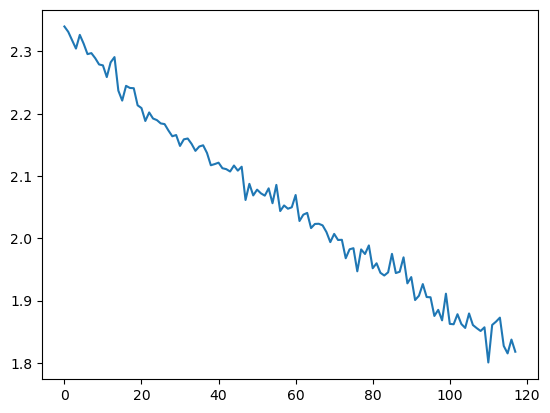

In [22]:
plt.plot(t_loss)    # can continue to train, but will waste some time haha
